In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matrixprofile import matrixProfile, motifs
from pyclustering.nnet.som import type_conn
import math
import os
import sys
sys.path.insert(0, os.path.abspath('../src'))
import dtwsom

In [2]:
D3011_data = np.load('dataset_TipAu_Au.npz')

In [3]:
D3011_data.keys()

KeysView(NpzFile 'dataset_TipAu_Au.npz' with keys: smoothedMeasuredHeight_m, vDeflection_N, height_m, measuredHeight_m, seriesTime_s...)

In [4]:
list(D3011_data.keys())

['smoothedMeasuredHeight_m',
 'vDeflection_N',
 'height_m',
 'measuredHeight_m',
 'seriesTime_s',
 'time_s']

In [5]:
force_data = D3011_data['vDeflection_N']

In [6]:
force_data.shape

(1024, 800)

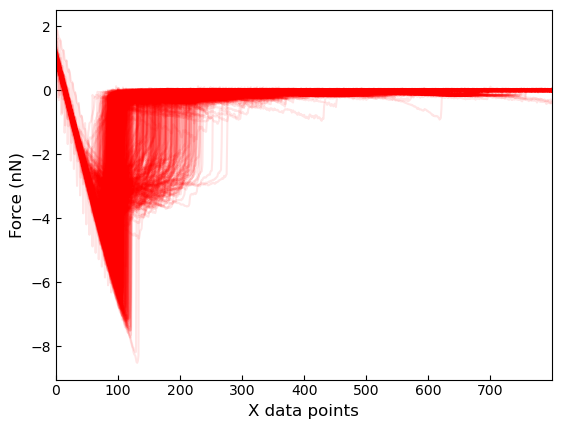

In [7]:
fig,ax = plt.subplots(dpi=100)

for curve in force_data:
    ax.plot(curve,c='red',alpha=0.1)

ax.set_xlabel('X data points',fontsize=12)
ax.set_ylabel('Force (nN)',fontsize=12)

ax.tick_params(labelsize=10,direction='in')

ax.set_xlim([0,force_data.shape[1]-1])

#fig.savefig('../data/figures/pca_examples/D3011_curves.png',dpi=300,bbox_inches='tight')

plt.show()

### Split dos dados

Separar as 100 primeiras séries temporais pq talvez o código não tanke com mais que isso.

In [8]:
train_set = force_data[:100]
test_set = force_data[100:]

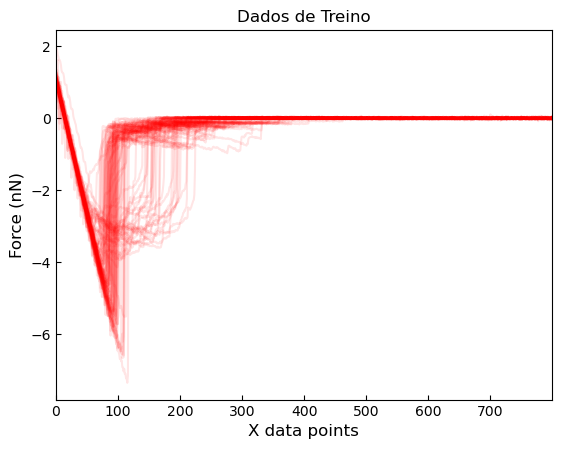

In [9]:
fig,ax = plt.subplots(dpi=100)

for curve in train_set:
    ax.plot(curve,c='red',alpha=0.1)

ax.set_xlabel('X data points',fontsize=12)
ax.set_ylabel('Force (nN)',fontsize=12)

ax.tick_params(labelsize=10,direction='in')

ax.set_xlim([0,force_data.shape[1]-1])

ax.set_title("Dados de Treino")

#fig.savefig('../data/figures/pca_examples/D3011_curves.png',dpi=300,bbox_inches='tight')

plt.show()

In [10]:
len(train_set[0])

800

In [11]:
train_set_cort = np.zeros((100,350))

for i in range(len(train_set_cort)):
    train_set_cort[i] = train_set[i][:350]

train_set_cort

array([[ 1.9760933e+00,  1.9316160e+00,  1.8887263e+00, ...,
        -8.1363340e-03,  1.7403450e-03, -1.8480760e-02],
       [ 1.2385187e+00,  1.1436823e+00,  1.0508256e+00, ...,
        -1.2077315e-02, -1.6735767e-02, -2.4817275e-02],
       [ 9.9519460e-01,  8.9909390e-01,  8.4386265e-01, ...,
        -4.7822705e-03, -1.7706990e-02, -3.6565723e-02],
       ...,
       [ 1.0334559e+00,  1.1225892e+00,  9.6069340e-01, ...,
         1.6398168e-02, -1.4502073e-02,  2.8732262e-03],
       [ 9.9495860e-01,  9.6008700e-01,  9.5344280e-01, ...,
        -1.3602034e-02, -2.5787856e-02, -4.6373153e-03],
       [ 1.1985062e+00,  1.0841645e+00,  1.0030030e+00, ...,
        -4.5358704e-03,  7.8056800e-03, -2.2303660e-02]])

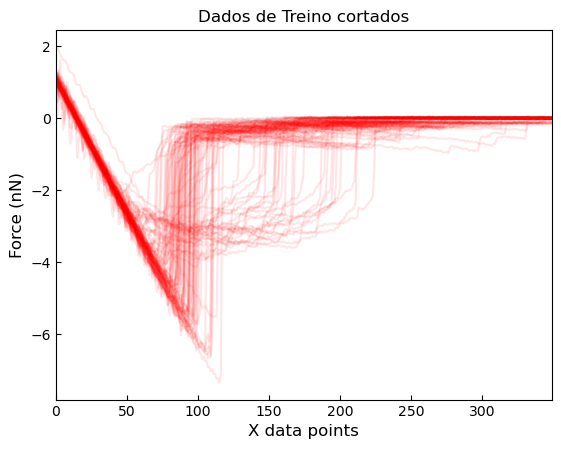

In [12]:
fig,ax = plt.subplots(dpi=100)

for curve in train_set_cort:
    ax.plot(curve,c='red',alpha=0.1)

ax.set_xlabel('X data points',fontsize=12)
ax.set_ylabel('Force (nN)',fontsize=12)

ax.tick_params(labelsize=10,direction='in')

ax.set_xlim([0,train_set_cort.shape[1]-1])

ax.set_title("Dados de Treino cortados")

#fig.savefig('../data/figures/pca_examples/D3011_curves.png',dpi=300,bbox_inches='tight')

plt.show()

### Concatenando os dados
Juntar tudo numa mesma série temporal, como indicado no artigo.

In [13]:
size = len(train_set_cort[0])
sample_size = len(train_set_cort)
print(size, sample_size)

350 100


In [14]:
joined_data = train_set_cort[0]
for i in range(1, sample_size):
    joined_data = np.concatenate((joined_data, train_set_cort[i]))
len(joined_data)

35000

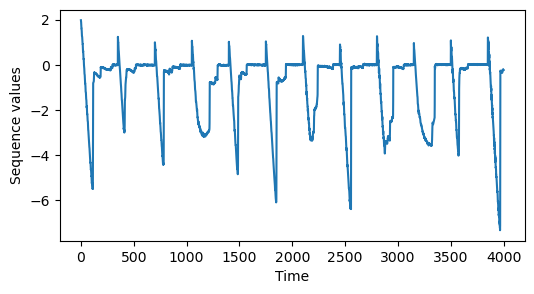

In [15]:
plt.figure(figsize=(6,3))
plt.plot(np.arange(4000), joined_data[:4000])
plt.ylabel("Sequence values")
plt.xlabel("Time")
plt.show()

In [16]:
%%time
mp = matrixProfile.stomp(joined_data, size)

CPU times: user 9.33 s, sys: 575 µs, total: 9.33 s
Wall time: 9.33 s


In [17]:
print(mp[1])

[ 1736.  1737.  1738. ... 22747. 22748. 22749.]


Somando uma matriz de zeros à matriz de perfil, assim, os valores de `Nan` se tornam numéricos e iguais a zero.

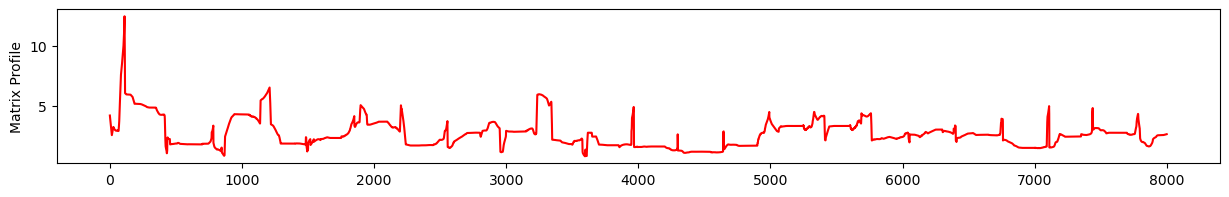

In [18]:
mp_adj = np.append(mp[0],np.zeros(size-1)+np.nan)

plt.figure(figsize=(15,2))
plt.plot(np.arange(8000), mp_adj[:8000], color='red')
plt.ylabel("Matrix Profile")
plt.show()

Extraindo os motifs.

In [19]:
%%time
mtfs, motif_d  = motifs.motifs(joined_data, mp, max_motifs=1000)
len(mtfs)

CPU times: user 86.4 ms, sys: 20 ms, total: 106 ms
Wall time: 106 ms


39

Criando uma lista com os centros de motifs.

In [20]:
motif_center_list = []
for motif in mtfs:
    center_pointers = list(np.arange(motif[0], motif[0]+size))
    motif_center = joined_data[center_pointers]
    motif_center_list.append(motif_center)

len(joined_data)

35000

In [21]:
len(motif_center_list)

39

### Treinando a rede DTW-SOM

In [22]:
%time
rows = 3
cols = 3
structure = type_conn.grid_four
network = dtwsom.DtwSom(rows, cols, structure)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


In [23]:
%%time
network.train(motif_center_list, 50)

Epoch 1 achieved an average quantization error of 5.6596
Epoch 2 achieved an average quantization error of 6.8004
Epoch 3 achieved an average quantization error of 6.3724
Epoch 4 achieved an average quantization error of 6.0936
Epoch 5 achieved an average quantization error of 6.2348
Epoch 6 achieved an average quantization error of 6.3279
Epoch 7 achieved an average quantization error of 6.444
Epoch 8 achieved an average quantization error of 6.2765
Epoch 9 achieved an average quantization error of 5.7934
Epoch 10 achieved an average quantization error of 5.9096
Epoch 11 achieved an average quantization error of 6.0153
Epoch 12 achieved an average quantization error of 6.0122
Epoch 13 achieved an average quantization error of 6.1273
Epoch 14 achieved an average quantization error of 6.144
Epoch 15 achieved an average quantization error of 6.1821
Epoch 16 achieved an average quantization error of 6.2312
Epoch 17 achieved an average quantization error of 6.1194
Epoch 18 achieved an aver

50

### Resultados

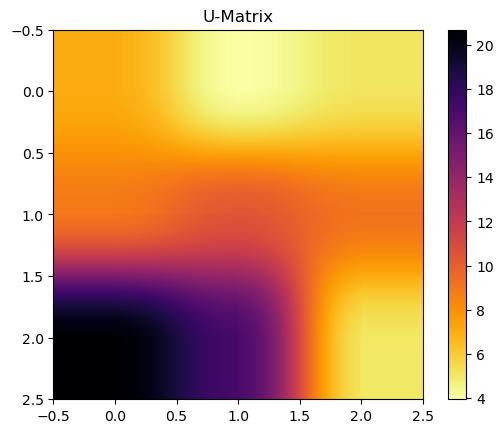

In [24]:
network.show_distance_matrix()

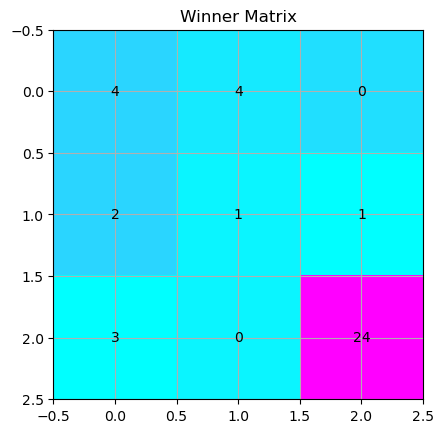

In [25]:
network.show_winner_matrix()

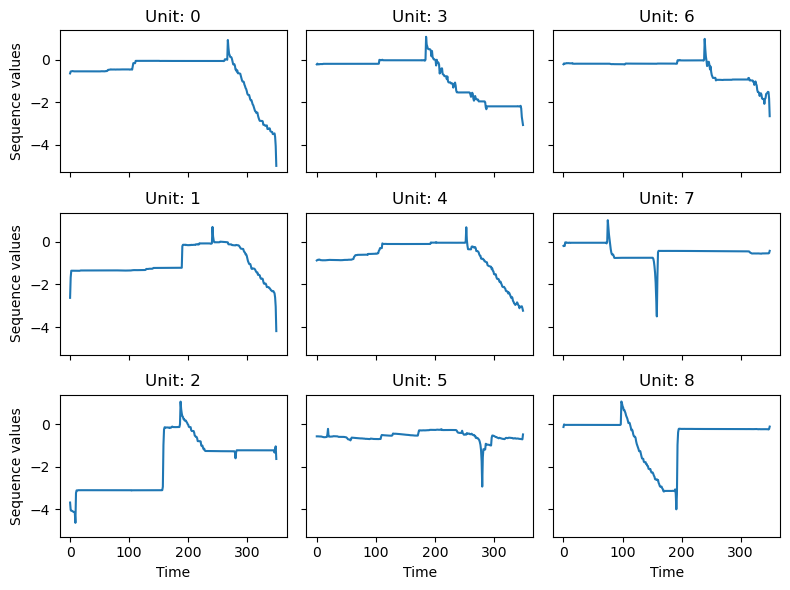

In [27]:
n_neurons = network._size
fig, axs = plt.subplots(3,3,figsize=(8, 6), sharex=True, sharey=True)
for neuron_index in range(n_neurons):
    col = math.floor(neuron_index/3) # round numbers down to the nearest integer:
    #math.ceil: round a number UP to the nearest integer
    row = neuron_index % 3
    neuron_weights = network._weights[neuron_index]
    axs[row, col].plot(np.arange(len(neuron_weights)), neuron_weights, label=str(neuron_index))
    axs[row, col].set_title("Unit: "+str(neuron_index))
    if col == 0:
        axs[row, col].set_ylabel("Sequence values")
    if row == 2:
        axs[row, col].set_xlabel("Time")
plt.tight_layout()
plt.show()

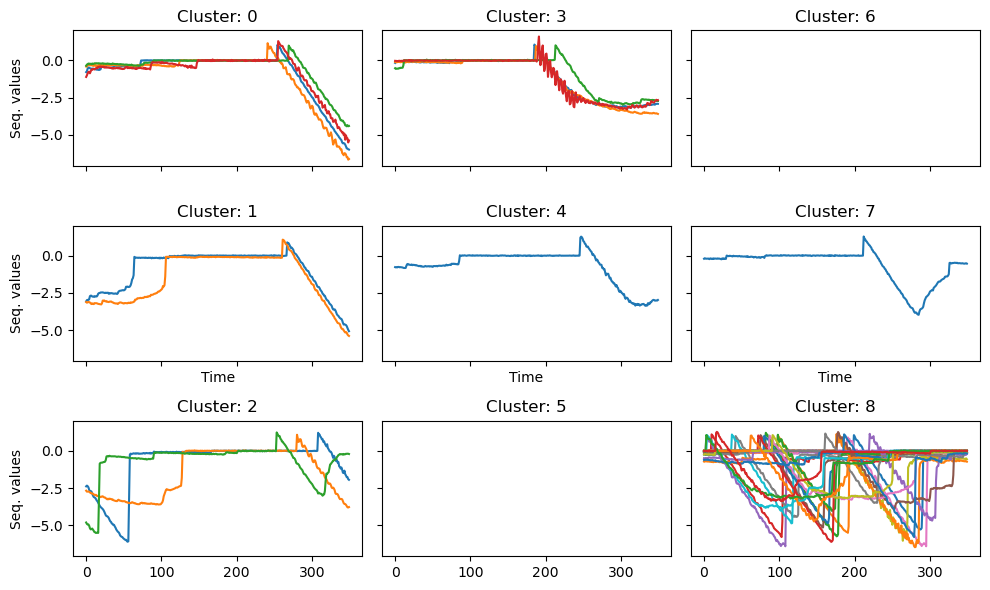

In [28]:
n = rows
n_neurons = network._size
fig, axs = plt.subplots(n,n,figsize=(10, 6), sharex=True, sharey=True)
for neuron_index in range(n_neurons):
    col = math.floor(neuron_index/n)
    row = neuron_index % n
    cluster_list = network.capture_objects[neuron_index]
    for member_index in cluster_list:
        axs[row, col].plot(np.arange(len(motif_center_list[member_index])), motif_center_list[member_index])
    axs[row, col].set_title("Cluster: "+str(neuron_index))
    if col == 0:
        axs[row, col].set_ylabel("Seq. values")
    if row == 1:
        axs[row, col].set_xlabel("Time")
plt.tight_layout()
plt.show()

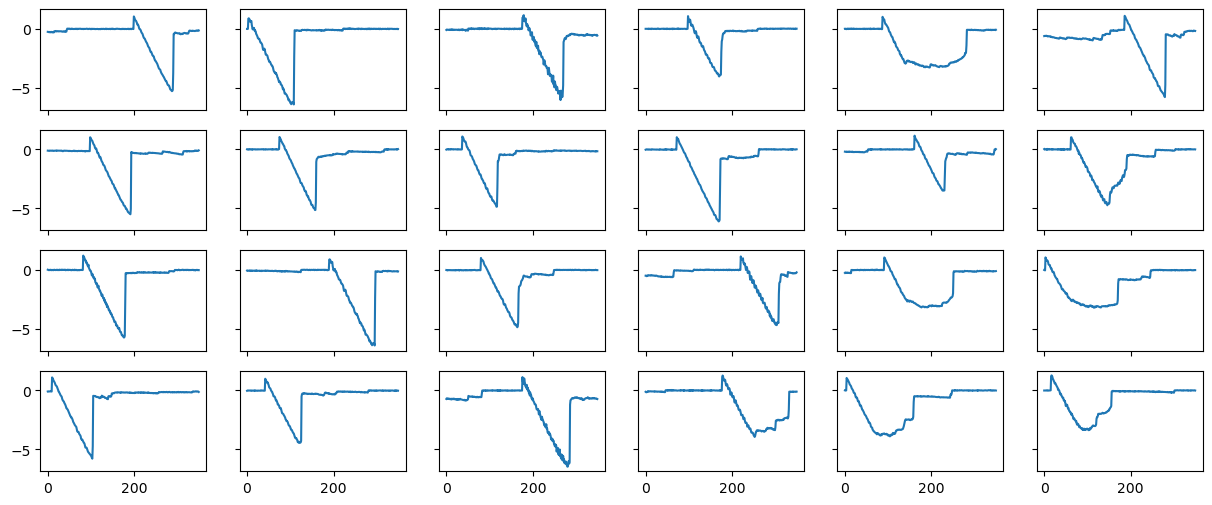

In [30]:
fig, axs = plt.subplots(4, 6,figsize=(15, 6), sharex=True, sharey=True)
cluster_list = network.capture_objects[8]
for i, member_index in enumerate(cluster_list):
    col = math.floor(i/4)
    row = i % 4
    axs[row, col].plot(np.arange(len(motif_center_list[member_index])), motif_center_list[member_index])
plt.show()